In [1]:
from helper import*
import params as cfg
import sys
sys.path.insert(1, '/Users/joshuaighalo/Documents/GitHub/eegDementia')

In [2]:
"Functions utilized in this script"
def multipleFilesNotch(input_3d,fs):
    notch_out = []
    filtering = filters()
    for i in range(input_3d.shape[0]):
        notch_out.append(filtering.notch(input_3d[i,:,:],fs))
    return np.array(notch_out)

def multipleFilesbutterBandpass(input_3d,lowcut,highcut,fs):
    butter_out = []
    filtering = filters()
    for i in range(input_3d.shape[0]):
        butter_out.append(filtering.butterBandPass(input_3d[i,:,:],lowcut,highcut,fs))
    return np.array(butter_out)

def multipleArtfRemoval(input_3d,threshold_value,timearray,len_window,step_size,choice_numwindows,channels,group):
    print(group)
    artf_out = []
    for i in range(input_3d.shape[0]):
        artf_out.append(ar_maximumgradient(input_3d[i,:,:],threshold_value,timearray,len_window,step_size,choice_numwindows,channels))
    print('***************************************************************************************************************************************************************')
    return np.array(artf_out)

def multiplePSD(data_4D,fs):
    freqs,psd = [],[]
    for i in range(data_4D.shape[0]):
        freqs.append(computePSD(data_4D[i],fs,data_type='3D')[0])
        psd.append(computePSD(data_4D[i],fs,data_type='3D')[1])
    psd = np.array(psd)
    freqs = np.array(freqs)
    return freqs,psd

def multipleRelativeBandPower(input_3d,freq_array,low,high):
    avg_out = []
    for i in range(input_3d.shape[0]):
        avg_out.append(psdRelativeBandPower(input_3d[i,:,:],freq_array,low,high))
    return np.array(avg_out)

def specgram_features(data,sfreq,NFFT,Noverlap,time,data_shape):

    def params_1D(data_1D,fs,win_len,win_overlap,spec_time): 
        s_px,s_fx,s_tx,s_imx = plt.specgram(data_1D, NFFT=win_len, Fs=fs, noverlap=win_overlap)
        s_tx = np.linspace(spec_time[0],spec_time[1],len(s_px.T))
        return s_px,s_fx,s_tx

    def params_2D(data_2D,sfreq,nfft,noverlap,spec_time):
#        input: data must be windowed to form 2D array
#               data_2D = (len_windows,num_windows)
#               sfreq = sampling frequency
#               nfft = number of points to use in the FFT
#               noverlap = number of points to overlap
            
#        output: psd = (len_freqs,len_time), freqs = (len_freqs,), time = (len_time,)

        psd,freqs,times = [],[],[]
        for i in range(len(data_2D.T)):
            s_px,s_fx,s_tx = params_1D(data_2D[:,i],sfreq,nfft,noverlap,spec_time)
            psd.append(s_px)
            freqs.append(s_fx)
            times.append(s_tx)
        psd,freqs,times = np.array(psd),np.array(freqs),np.array(times)
        psd = np.nanmean(psd,axis=0)
        return psd,freqs,times

    def params_3D(data_3D,sfreq,nfft,noverlap,spec_time):
#        input: data must be windowed to form 3D array
#               data_3D = (num_channels,len_windows,num_windows)
#               sfreq = sampling frequency
#               nfft = number of points to use in the FFT
#               noverlap = number of points to overlap
            
#        output: psd = (num_channels,len_freqs,len_time), freqs = (len_freqs,), time = (len_time,)

        psd,freqs,times = [],[],[]
        for i in range(data_3D.shape[0]):
            s_px,s_fx,s_tx = params_2D(data_3D[i,:,:],sfreq,nfft,noverlap,spec_time)
            psd.append(s_px)
            freqs.append(s_fx)
            times.append(s_tx)
        psd,freqs,times = np.array(psd),np.array(freqs),np.array(times)
        return psd,freqs,times

    def params_4D(data_4D,sfreq,nfft,noverlap,spec_time):
#        input: data must be windowed to form 4D array
#               data_4D = (num_participants,num_channels,len_windows,num_windows)
#               sfreq = sampling frequency
#               nfft = number of points to use in the FFT
#               noverlap = number of points to overlap
            
#        output: psd = (num_participants,num_channels,len_freqs,len_time), freqs = (len_freqs,), time = (len_time,)
        psd,freqs,times = [],[],[]
        for i in range(data_4D.shape[0]):
            s_px,s_fx,s_tx = params_3D(data_4D[i,:,:,:],sfreq,nfft,noverlap,spec_time)
            psd.append(s_px)
            freqs.append(s_fx)
            times.append(s_tx)
        psd,freqs,times = np.array(psd),np.array(freqs),np.array(times)
        return psd,freqs,times
    
    if data_shape == '1D':
        s_psd,s_freqs,s_times = params_1D(data,sfreq,NFFT,Noverlap,time)
    elif data_shape == '2D':
        s_psd,s_freqs,s_times = params_2D(data,sfreq,NFFT,Noverlap,time)
    elif data_shape == '3D':
        s_psd,s_freqs,s_times = params_3D(data,sfreq,NFFT,Noverlap,time)
    elif data_shape == '4D':
        s_psd,s_freqs,s_times = params_4D(data,sfreq,NFFT,Noverlap,time)
    return s_psd,s_freqs,s_times

In [3]:
"""
#   Group-Task-Time
M11 = ['m11_1.zip','m11_2.zip','m11_3.zip','m11_4.zip','m11_5.zip']
M21 = ['m21_1.zip','m21_2.zip','m21_3.zip','m21_4.zip','m21_5.zip']
M12 = ['m12_1.zip','m12_2.zip','m12_3.zip','m12_4.zip','m12_5.zip']
M22 = ['m22_1.zip','m22_2.zip','m22_3.zip','m22_4.zip','m22_5.zip']
C11 = ['c11_1.zip','c11_2.zip','c11_3.zip','c11_4.zip','c11_5.zip']
C21 = ['c21_1.zip','c21_2.zip','c21_3.zip','c21_4.zip','c21_5.zip']
C12 = ['c12_1.zip','c12_2.zip','c12_3.zip','c12_4.zip','c12_5.zip']
C22 = ['c22_1.zip','c22_2.zip','c22_3.zip','c22_4.zip','c22_5.zip']
localDir = "/Users/joshuaighalo/Downloads/v2/"
destDir = "/Users/joshuaighalo/Downloads/v2/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'
"""

'\n#   Group-Task-Time\nM11 = [\'m11_1.zip\',\'m11_2.zip\',\'m11_3.zip\',\'m11_4.zip\',\'m11_5.zip\']\nM21 = [\'m21_1.zip\',\'m21_2.zip\',\'m21_3.zip\',\'m21_4.zip\',\'m21_5.zip\']\nM12 = [\'m12_1.zip\',\'m12_2.zip\',\'m12_3.zip\',\'m12_4.zip\',\'m12_5.zip\']\nM22 = [\'m22_1.zip\',\'m22_2.zip\',\'m22_3.zip\',\'m22_4.zip\',\'m22_5.zip\']\nC11 = [\'c11_1.zip\',\'c11_2.zip\',\'c11_3.zip\',\'c11_4.zip\',\'c11_5.zip\']\nC21 = [\'c21_1.zip\',\'c21_2.zip\',\'c21_3.zip\',\'c21_4.zip\',\'c21_5.zip\']\nC12 = [\'c12_1.zip\',\'c12_2.zip\',\'c12_3.zip\',\'c12_4.zip\',\'c12_5.zip\']\nC22 = [\'c22_1.zip\',\'c22_2.zip\',\'c22_3.zip\',\'c22_4.zip\',\'c22_5.zip\']\nlocalDir = "/Users/joshuaighalo/Downloads/v2/"\ndestDir = "/Users/joshuaighalo/Downloads/v2/dest/"\nos.system(\'rm -rf %s/*\' % destDir)\nfs_setting = \'constant\'\n'

In [4]:
#"""
#   Group-Task-Time Ryan SEEN
M11 = ['m11_1.zip','m11_2.zip','m11_3.zip','m11_4.zip','m11_5.zip']
C21 = ['m21_1.zip','m21_2.zip','m21_3.zip','m21_4.zip','m21_5.zip']
M12 = ['m12_1.zip','m12_2.zip','m12_3.zip','m12_4.zip','m12_5.zip']
C22 = ['m22_1.zip','m22_2.zip','m22_3.zip','m22_4.zip','m22_5.zip']
C11 = ['c11_1.zip','c11_2.zip','c11_3.zip','c11_4.zip','c11_5.zip']
M21 = ['c21_1.zip','c21_2.zip','c21_3.zip','c21_4.zip','c21_5.zip']
C12 = ['c12_1.zip','c12_2.zip','c12_3.zip','c12_4.zip','c12_5.zip']
M22 = ['c22_1.zip','c22_2.zip','c22_3.zip','c22_4.zip','c22_5.zip']
localDir = "/Users/joshuaighalo/Downloads/v2/"
destDir = "/Users/joshuaighalo/Downloads/v2/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'
#"""

In [5]:
#   Extract eeg data from participants within the groups
M11 = zipExtract(M11,localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
M21 = zipExtract(M21,localDir,destDir,"M21",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
M12 = zipExtract(M12,localDir,destDir,"M12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
M22 = zipExtract(M22,localDir,destDir,"M22",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C11 = zipExtract(C11,localDir,destDir,"C11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C21 = zipExtract(C21,localDir,destDir,"C21",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C12 = zipExtract(C12,localDir,destDir,"C12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C22 = zipExtract(C22,localDir,destDir,"C22",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
time_s = np.arange(0,cfg.collection_time,1/cfg.fs)

In [6]:
#   Notch filters data collected from participants
noc_M11 = multipleFilesNotch(M11,cfg.fs)
noc_M21 = multipleFilesNotch(M21,cfg.fs)
noc_M12 = multipleFilesNotch(M12,cfg.fs)
noc_M22 = multipleFilesNotch(M22,cfg.fs)
noc_C11 = multipleFilesNotch(C11,cfg.fs)
noc_C21 = multipleFilesNotch(C21,cfg.fs)
noc_C12 = multipleFilesNotch(C12,cfg.fs)
noc_C22 = multipleFilesNotch(C22,cfg.fs)

In [7]:
#   Bandpass filters data collected from participants
band_M11 = multipleFilesbutterBandpass(noc_M11,cfg.lowcut,cfg.highcut,cfg.fs)
band_M21 = multipleFilesbutterBandpass(noc_M21,cfg.lowcut,cfg.highcut,cfg.fs)
band_M12 = multipleFilesbutterBandpass(noc_M12,cfg.lowcut,cfg.highcut,cfg.fs)
band_M22 = multipleFilesbutterBandpass(noc_M22,cfg.lowcut,cfg.highcut,cfg.fs)
band_C11 = multipleFilesbutterBandpass(noc_C11,cfg.lowcut,cfg.highcut,cfg.fs)
band_C21 = multipleFilesbutterBandpass(noc_C21,cfg.lowcut,cfg.highcut,cfg.fs)
band_C12 = multipleFilesbutterBandpass(noc_C12,cfg.lowcut,cfg.highcut,cfg.fs)
band_C22 = multipleFilesbutterBandpass(noc_C22,cfg.lowcut,cfg.highcut,cfg.fs)

In [ ]:
threshold_value,window_size,step_size,channels,choice_numwindows = 10,0.1,0.1,['TP9','AF7','AF8','TP10'],100
arM11 = multipleArtfRemoval(band_M11,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"M11")
arM21 = multipleArtfRemoval(band_M21,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"M21")
arM12 = multipleArtfRemoval(band_M12,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"M12")
arM22 = multipleArtfRemoval(band_M22,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"M22")
arC11 = multipleArtfRemoval(band_C11,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"C11")
arC21 = multipleArtfRemoval(band_C21,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"C21")
arC12 = multipleArtfRemoval(band_C12,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"C12")
arC22 = multipleArtfRemoval(band_C22,threshold_value,time_s,window_size,step_size,choice_numwindows,channels,"C22")

## Frequency Domain

In [9]:
# arGroup = (participants,channels,num_windows,len_windows)
# arrGroup = (participants,channels,len_windows,num_windows)
arr_M11 = np.transpose(arM11,(0,1,3,2))
arr_M21 = np.transpose(arM21,(0,1,3,2))
arr_M12 = np.transpose(arM12,(0,1,3,2))
arr_M22 = np.transpose(arM22,(0,1,3,2))
arr_C11 = np.transpose(arC11,(0,1,3,2))
arr_C21 = np.transpose(arC21,(0,1,3,2))
arr_C12 = np.transpose(arC12,(0,1,3,2))
arr_C22 = np.transpose(arC22,(0,1,3,2))

<b>Extract PSD, Frequencies and Time from spectrogram

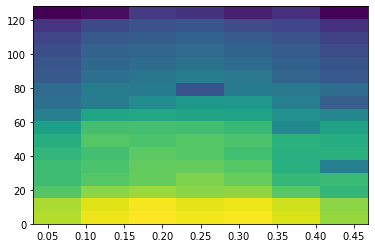

In [10]:
fs,nfft,overlap,spectral_time = 256,64,60,[0,500]
s_pxM11,s_fxM11,s_txM11 = specgram_features(arr_M11,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxM12,s_fxM12,s_txM12 = specgram_features(arr_M12,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxM21,s_fxM21,s_txM21 = specgram_features(arr_M21,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxM22,s_fxM22,s_txM22 = specgram_features(arr_M22,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC11,s_fxC11,s_txC11 = specgram_features(arr_C11,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC12,s_fxC12,s_txC12 = specgram_features(arr_C12,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC21,s_fxC21,s_txC21 = specgram_features(arr_C21,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC22,s_fxC22,s_txC22 = specgram_features(arr_C22,fs,nfft,overlap,spectral_time,data_shape='4D')

In [11]:
#  Average power bins across participants
meanpar_pxM11,meanpar_pxM12,meanpar_pxM21,meanpar_pxM22 = np.nanmean(s_pxM11,axis=0),np.nanmean(s_pxM12,axis=0),np.nanmean(s_pxM21,axis=0),np.nanmean(s_pxM22,axis=0)
meanpar_pxC11,meanpar_pxC12,meanpar_pxC21,meanpar_pxC22 = np.nanmean(s_pxC11,axis=0),np.nanmean(s_pxC12,axis=0),np.nanmean(s_pxC21,axis=0),np.nanmean(s_pxC22,axis=0)

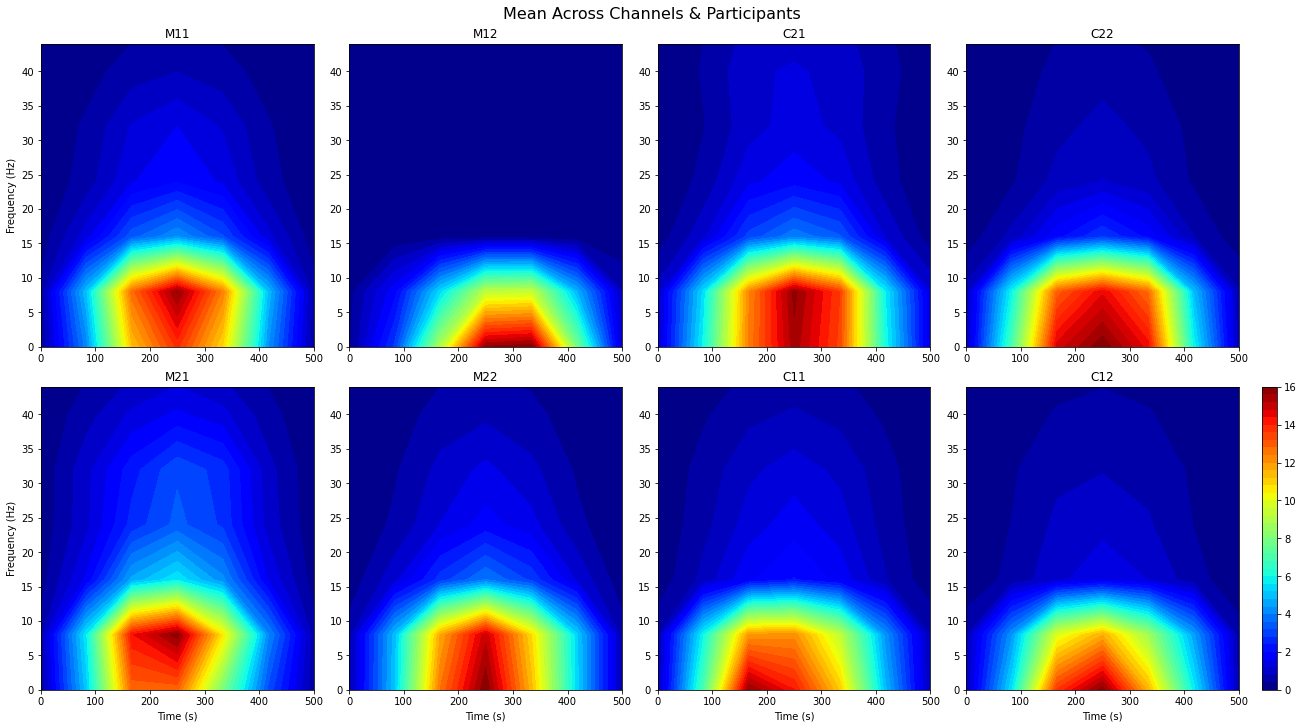

In [12]:
#  Average power bins across participants and channels
meanparchan_pxM11,meanparchan_pxM12,meanparchan_pxM21,meanparchan_pxM22 = np.nanmean(meanpar_pxM11,axis=0),np.nanmean(meanpar_pxM12,axis=0),np.nanmean(meanpar_pxM21,axis=0),np.nanmean(meanpar_pxM22,axis=0)
meanparchan_pxC11,meanparchan_pxC12,meanparchan_pxC21,meanparchan_pxC22 = np.nanmean(meanpar_pxC11,axis=0),np.nanmean(meanpar_pxC12,axis=0),np.nanmean(meanpar_pxC21,axis=0),np.nanmean(meanpar_pxC22,axis=0)
freqs,time = s_fxM11[0,0,0,:],s_txM11[0,0,0,:]

fig, ax = plt.subplots(2,4, figsize=(18,10), constrained_layout=True)
fig.suptitle('Mean Across Channels & Participants', fontsize=16)
ax[0,0].set_title('M11')
ax[0,1].set_title('M12')
ax[0,2].set_title('C21')
ax[0,3].set_title('C22')
ax[1,0].set_title('M21')
ax[1,1].set_title('M22')
ax[1,2].set_title('C11')
ax[1,3].set_title('C12')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_xlabel('Time (s)')
ax[1,1].set_xlabel('Time (s)')
ax[1,2].set_xlabel('Time (s)')
ax[1,3].set_xlabel('Time (s)')
ax[0,0].set_ylim(0,44)
ax[0,1].set_ylim(0,44)
ax[0,2].set_ylim(0,44)
ax[0,3].set_ylim(0,44)
ax[1,0].set_ylim(0,44)
ax[1,1].set_ylim(0,44)
ax[1,2].set_ylim(0,44)
ax[1,3].set_ylim(0,44)
levels = 45
spectrum = ax[0,0].contourf(time, freqs, meanparchan_pxM11,levels,cmap='jet')
spectrum = ax[0,1].contourf(time, freqs, meanparchan_pxM12,levels,cmap='jet')
spectrum = ax[0,2].contourf(time, freqs, meanparchan_pxC21,levels,cmap='jet')
spectrum = ax[0,3].contourf(time, freqs, meanparchan_pxC22,levels,cmap='jet')
spectrum = ax[1,0].contourf(time, freqs, meanparchan_pxM21,levels,cmap='jet')
spectrum = ax[1,1].contourf(time, freqs, meanparchan_pxM22,levels,cmap='jet')
spectrum = ax[1,2].contourf(time, freqs, meanparchan_pxC11,levels,cmap='jet')
spectrum = ax[1,3].contourf(time, freqs, meanparchan_pxC12,levels,cmap='jet')
cbar = plt.colorbar(spectrum)
plt.show()
    
    